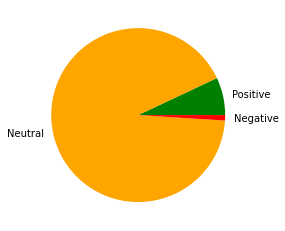

In [10]:
from tweepy.streaming import StreamListener
from tweepy import OAuthHandler, Stream, API, Cursor
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import re
from textblob import TextBlob

import twitter_credentials as tc

class TwitterAuthenticator():
    
    def authenticate_twitter_app(self):
        auth = OAuthHandler(tc.CONSUMER_KEY, tc.CONSUMER_SECRET)
        auth.set_access_token(tc.ACCESS_TOKEN, tc.ACCESS_TOKEN_SECRET)
        return auth

class TwitterClient():
    
    def __init__(self, twitter_user=None):
        self.auth = TwitterAuthenticator().authenticate_twitter_app()
        self.twitter_client = API(self.auth)

        self.twitter_user = twitter_user

    def get_twitter_client_api(self):
        return self.twitter_client
    
    def get_tweet_by_keywords(self, keyword):
        tweets = []
        for tweet in Cursor(self.twitter_client.search, q=keyword, lang='tl').items(100):
            tweets.append(tweet)
        return tweets    
    
class TweetAnalyzer():
    """Functionality for analyzing and categorizing content from tweets."""
    
    def clean_tweet(self, tweet):
        return ' '.join(re.sub("(@[A-Za-z0-9]+)|([^0-9A-Za-z \t])|(\w+:\/\/\S+)", " ", tweet).split())
    
    def tweets_to_data_frame(self, tweets):
        df = pd.DataFrame(data=[tweet.text for tweet in tweets], columns=['Tweets'])
        
        df['id'] = np.array([tweet.id for tweet in tweets])
        df['length'] = np.array([len(tweet.text) for tweet in tweets])
        df['source'] = np.array([tweet.source for tweet in tweets])
        df['created_at'] = np.array([tweet.created_at for tweet in tweets])
        df['retweets'] = np.array([tweet.retweet_count for tweet in tweets])
        df['language'] = np.array([tweet.lang for tweet in tweets])
        
        return df
    
    def analyze_sentiment(self, tweet):
        analysis = TextBlob(self.clean_tweet(tweet))
        
        pl = analysis.sentiment.polarity
        
        if pl > 0:
            return 1
        elif pl == 0:
            return 0
        else:
            return -1
        
if __name__ == "__main__":
    
    tw = TwitterClient()
    
    ta = TweetAnalyzer()
    
    tweets = tw.get_tweet_by_keywords("#covid")
    df = ta.tweets_to_data_frame(tweets)
    df['sentiment'] = np.array([ta.analyze_sentiment(tweet) for tweet in df['Tweets']])
    
    sentiments = df['sentiment']
    
    pos_pol = 0
    neu_pol = 0
    neg_pol = 0
    
    for s in sentiments:
        if s == 1:
            pos_pol += 1
        elif s == 0:
            neu_pol += 1
        else:
            neg_pol += 1
    
    counts = np.array([pos_pol, neu_pol, neg_pol])
    labels = ['Positive', 'Neutral', 'Negative']
    colors = ['green', 'orange', 'red']
    
    plt.pie(counts, labels=labels, colors=colors)
    plt.show()